# Лабораторная №4

__Замена цветов на их коды (применение палитры цветов) на GPU.__

Входные данные: изображение в формате RGB24, где общее количество цветов не превышает порога в 256 значений. (Для получения такого рисунка рекомендуется открыть исходное изображение в редакторе Paint и сохранить его как «256-и цветный рисунок»)

* Предварительно на CPU потребуется составить палитру, сопоставив каждому встреченному в изображении 3-х байтовому цвету однобайтовый код.
* Функция-ядро должна сформировать изображение, где все пиксели будут заменены на их коды в соответствии с составленной палитрой.
* Потребуется также реализовать на CPU декодирование изображения, то есть обратную замену кодов на соответствующие им пиксели. Для проверки корректности выполнения программы в конце должно выполняться побайтовое сравнение исходного и декодированного изображений.
* Затем, после отладки базовой реализации, следует реализовать вариант, при котором палитра цветов помещается в константную память, и сравнить время выполнения с первоначальным вариантом.


## Импорт библиотек

In [75]:
import time

# Для картинок
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.cuda as cuda
import torch.nn.functional as F

import tensorflow as tf

import numba
from numba import cuda, types

In [80]:
import warnings
current_warning_settings = warnings.simplefilter("ignore")

## Глобальные переменные

In [115]:
# Определение максимального размера палитры
MAX_PALETTE_SIZE = 256

## Проверка среды GPU

In [4]:
!nvidia-smi

Sun Dec 24 05:19:34 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
torch.cuda.is_available()
# Output would be True if Pytorch is using GPU otherwise it would be False.

True

In [ ]:
tf.test.gpu_device_name()
# Standard output is '/device:GPU:0'

'/device:GPU:0'

## Загрузка изображений


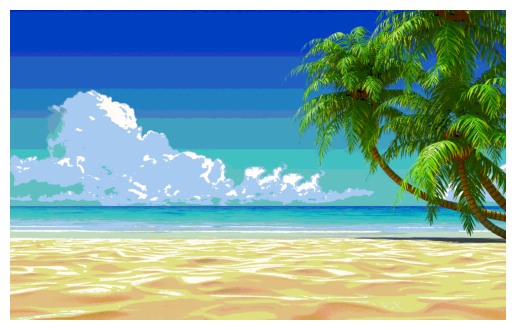

Количество уникальных цветов в изображении: 151


In [12]:
image_path = '/content/drive/My Drive/Университет/Технологии обработки Big Data/image.bmp'
original_image = cv2.imread(image_path)

if original_image is not None:
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    plt.imshow(original_image)
    plt.axis('off')
    plt.show()
else:
    print("Не удалось загрузить изображение. Проверь правильность пути.")

unique_colors, counts = np.unique(original_image.reshape(-1, 3), axis=0, return_counts=True)
num_unique_colors = len(unique_colors)
print("Количество уникальных цветов в изображении:", num_unique_colors)

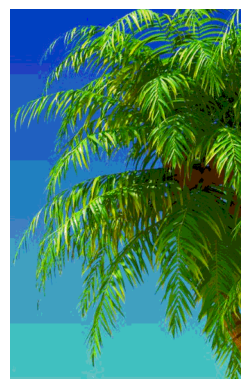

Количество уникальных цветов в изображении: 122


In [13]:
image_path = '/content/drive/My Drive/Университет/Технологии обработки Big Data/image_обрез.bmp'
original_image_crop = cv2.imread(image_path)

if original_image_crop is not None:
    original_image_crop = cv2.cvtColor(original_image_crop, cv2.COLOR_BGR2RGB)
    plt.imshow(original_image_crop)
    plt.axis('off')
    plt.show()
else:
    print("Не удалось загрузить изображение. Проверь правильность пути.")

unique_colors, counts = np.unique(original_image_crop.reshape(-1, 3), axis=0, return_counts=True)
num_unique_colors = len(unique_colors)
print("Количество уникальных цветов в изображении:", num_unique_colors)

## CPU-реализация

In [5]:
# Функция создания палитры
def create_palette(image):
    # Используем np.unique для поиска уникальных цветов и их количества в изображении
    unique_colors, counts = np.unique(image.reshape(-1, 3), axis=0, return_counts=True)
    # Преобразуем уникальные цвета в список и возвращаем
    palette = unique_colors.tolist()
    return palette

# Функция кодирования изображения
def encode_image(image, palette):
    # Инициализируем закодированное изображение нулями того же размера и типа, что и оригинальное изображение
    encoded_image = np.zeros_like(image[:, :, 0], dtype=np.uint8)
    # Проходим по каждому пикселю изображения
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # Получаем цвет текущего пикселя в виде списка
            pixel = image[i, j].tolist()
            # Находим индекс цвета в палитре и записываем его в закодированное изображение
            index = palette.index(pixel)
            encoded_image[i, j] = index
    return encoded_image

# Функция декодирования изображения
def decode_image(encoded_image, palette):
    # Инициализируем декодированное изображение нулями того же размера и типа, что и закодированное изображение
    decoded_image = np.zeros((encoded_image.shape[0], encoded_image.shape[1], 3), dtype=np.uint8)
    # Проходим по каждому пикселю закодированного изображения
    for i in range(encoded_image.shape[0]):
        for j in range(encoded_image.shape[1]):
            # Получаем код текущего пикселя
            code = encoded_image[i, j]
            # Находим соответствующий цвет в палитре и записываем его в декодированное изображение
            decoded_image[i, j] = np.array(palette[int(code)], dtype=np.uint8)
    return decoded_image

In [6]:
start_palette = time.time()
# Создание палитры
palette = create_palette(original_image)
end_palette = time.time()

start_coding = time.time()
# Кодирование изображения
encoded_image = encode_image(original_image, palette)
end_coding = time.time()

start_decoding = time.time()
# Декодирование изображения
decoded_image = decode_image(encoded_image, palette)
end_decoding = time.time()

# Побайтовое сравнение исходного и декодированного изображений
if np.array_equal(original_image, decoded_image):
    print("Декодирование выполнено корректно")
else:
    print("Декодирование не удалось")

palette_time_CPU = end_palette - start_palette
coding_time_CPU = end_coding - start_coding
decoding_time_CPU = end_decoding - start_decoding
all_time_CPU = palette_time_CPU + coding_time_CPU + decoding_time_CPU

print(f"Общее время выполнения на CPU: {all_time_CPU:.2f} сек")
print(f"Время создания палитры на CPU: {palette_time_CPU:.2f} сек")
print(f"Время кодирования изображения на CPU: {coding_time_CPU:.2f} сек")
print(f"Время декодирования изображения на CPU: {decoding_time_CPU:.2f} сек")

Декодирование выполнено корректно
Общее время выполнения на CPU: 13.51 сек
Время создания палитры на CPU: 5.95 сек
Время кодирования изображения на CPU: 4.55 сек
Время декодирования изображения на CPU: 3.00 сек


#### Результаты

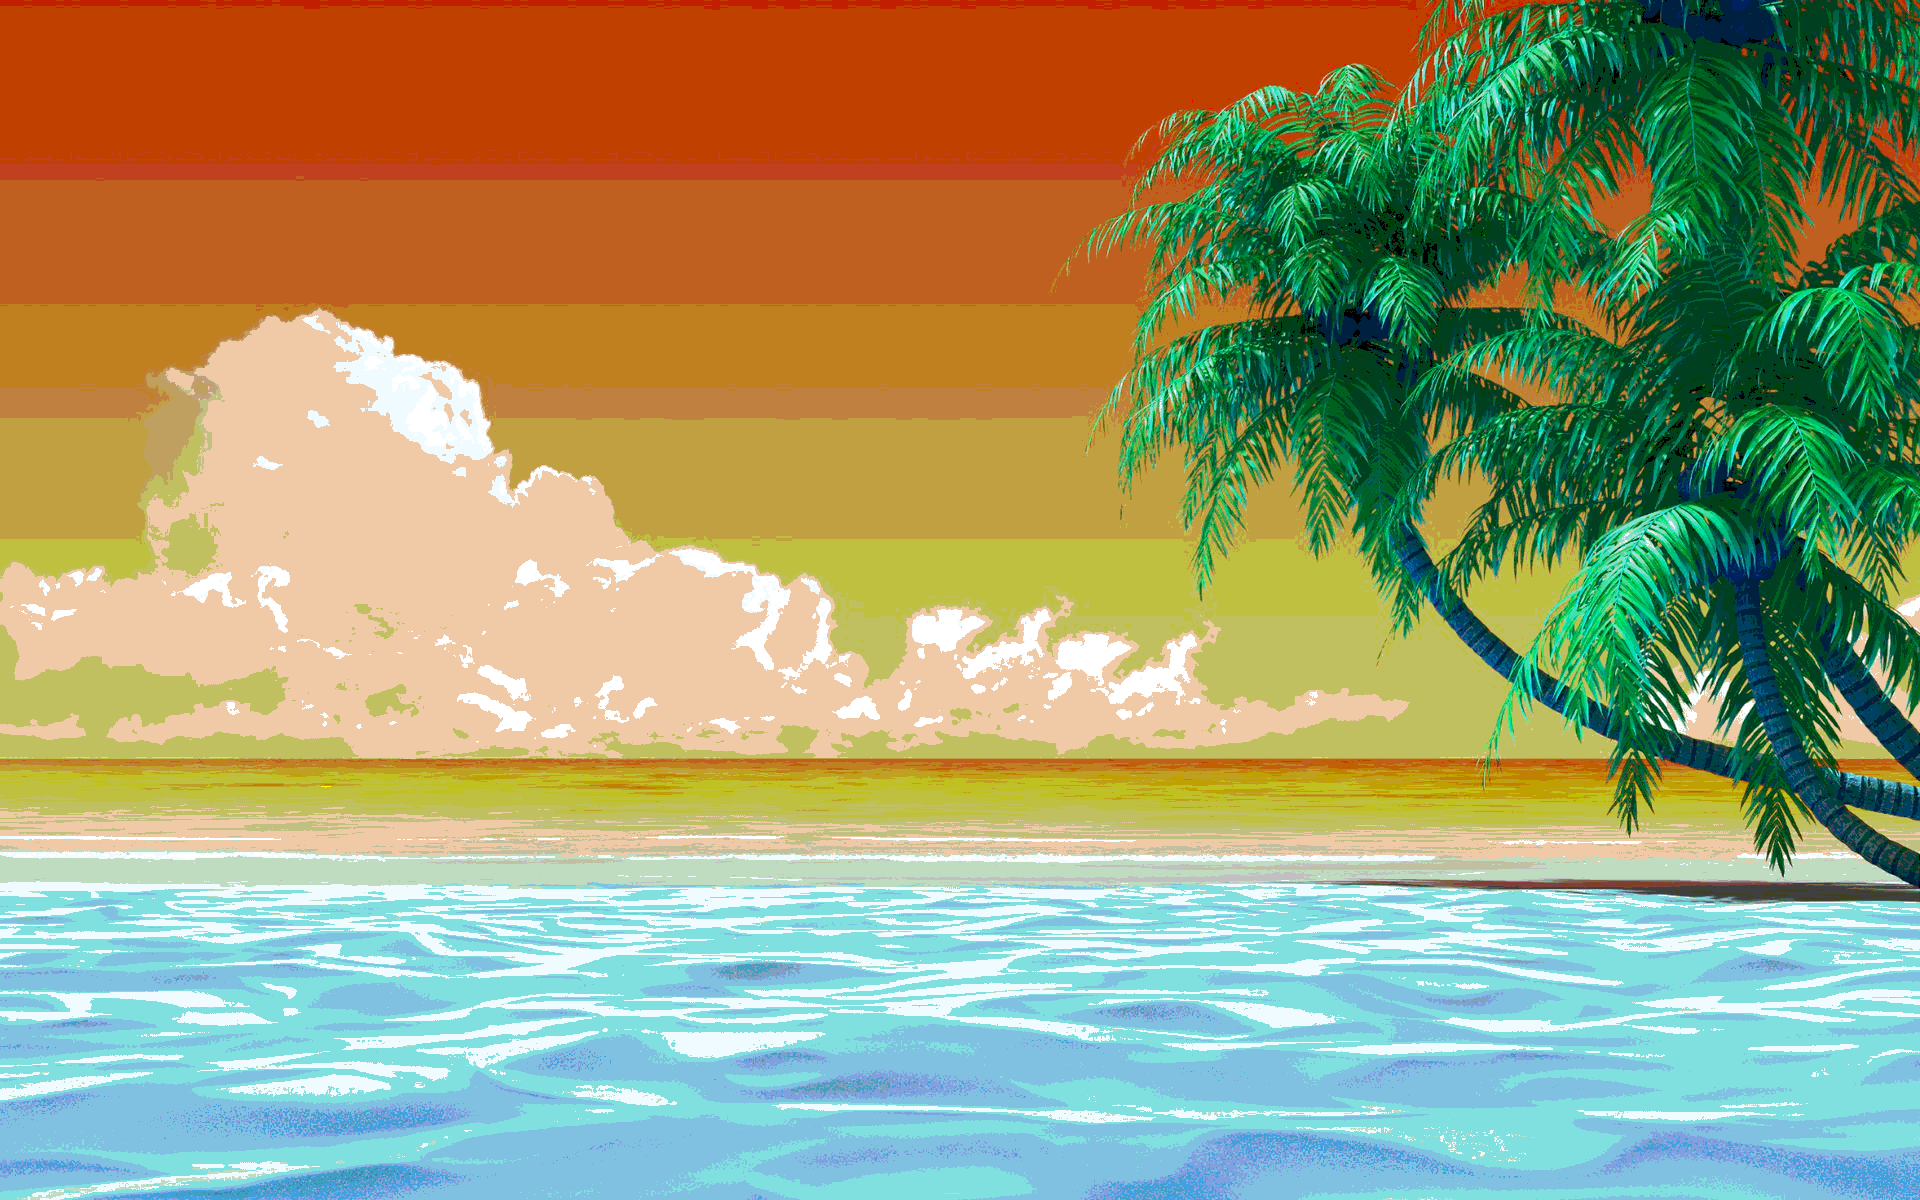

In [7]:
# Начальное изображение с глубиной цвета в 3 байта
cv2_imshow(original_image)

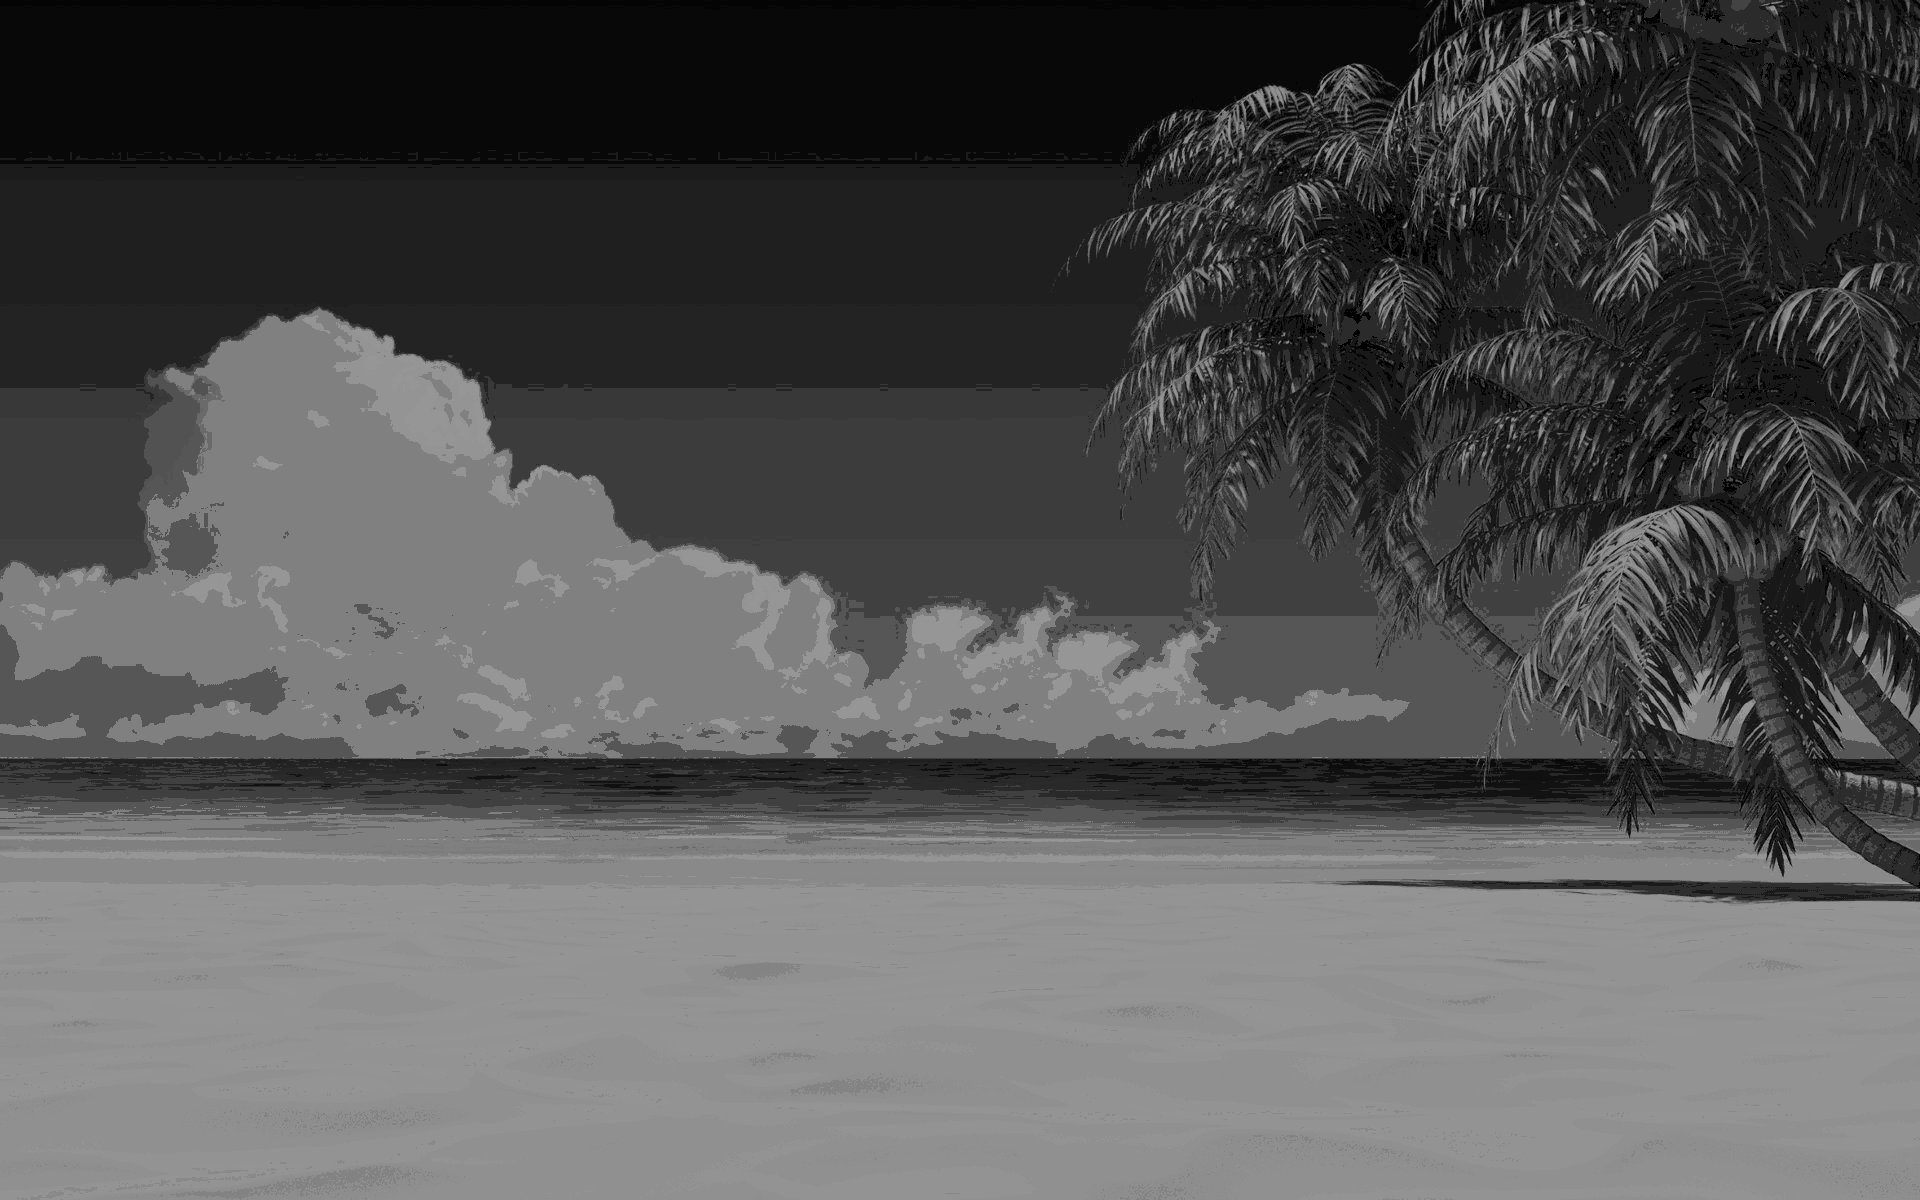

In [8]:
# Закодированое изображение с глубиной цвета в 1 байт
cv2_imshow(encoded_image)

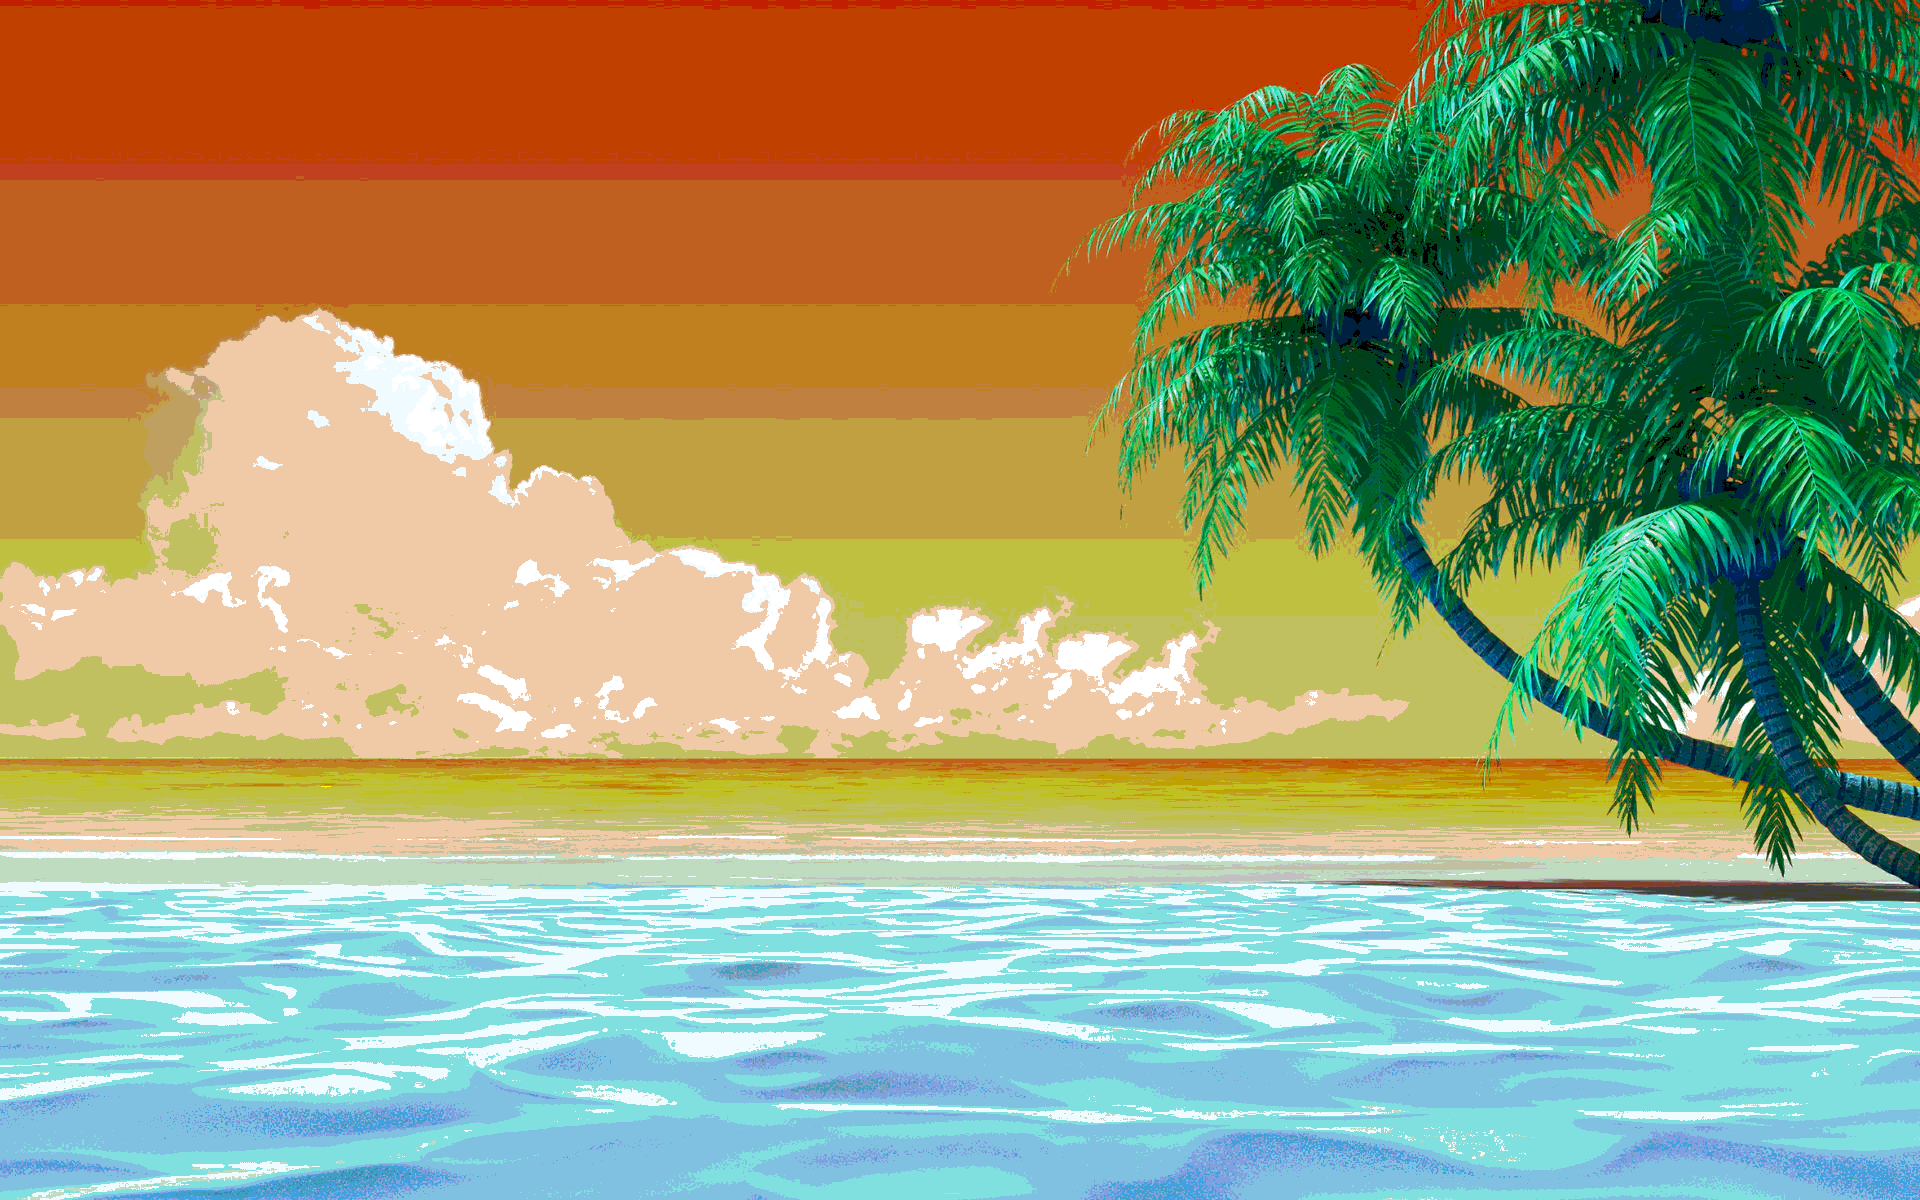

In [9]:
# Декодированое изображение с глубиной цвета в 3 байта
cv2_imshow(decoded_image)

## GPU-реализация

### Реализация в PyTorch

In [117]:
# Функция перемещения картинки на GPU
def move_to_gpu(image):
    # Преобразуем изображение в тензор и перемещаем на устройство GPU
    image_tensor = torch.from_numpy(image).to(device="cuda")
    return image_tensor

# Функция создания палитры на CPU
def create_palette(image_tensor):
    # Находим уникальные цвета в изображении и преобразуем их в список
    unique_colors = torch.unique(image_tensor.view(-1, 3), dim=0)
    palette = unique_colors.tolist()
    return palette

# Функция перемещения палитры на GPU
def move_palette_to_gpu(palette):
    # Преобразуем палитру в тензор и перемещаем на устройство GPU
    palette_tensor = torch.tensor(palette, dtype=torch.uint8).to(device="cuda")
    return palette_tensor

# Функция кодирования изображения
def encode_image(image_tensor, palette):
    with torch.cuda.device("cuda"):
        encoded_image = torch.zeros_like(image_tensor[:, :, 0], dtype=torch.uint8)
        indices = torch.tensor([palette.index(pixel.tolist()) for pixel in image_tensor.view(-1, 3)], dtype=torch.uint8)
        encoded_image = indices.view(image_tensor.shape[:2])
    return encoded_image

# Функция декодирования изображения
def decode_image(encoded_image, palette):
    # Инициализируем декодированное изображение нулями того же размера и типа, что и закодированное изображение
    decoded_image = torch.zeros((encoded_image.shape[0], encoded_image.shape[1], 3), dtype=torch.uint8)
    # Проходим по каждому пикселю закодированного изображения
    for i in range(encoded_image.shape[0]):
        for j in range(encoded_image.shape[1]):
            # Получаем код текущего пикселя
            code = encoded_image[i, j]
            # Находим соответствующий цвет в палитре и записываем его в декодированное изображение
            decoded_image[i, j] = torch.tensor(palette[int(code)], dtype=torch.uint8)
    return decoded_image

In [118]:
start_transfer_to_GPU = time.time()
# Перемещение оригинального изображения на GPU
original_image_tensor = move_to_gpu(original_image)
end_transfer_to_GPU = time.time()

start_palette = time.time()
# Создание палитры
palette = create_palette(original_image_tensor)
# Перемещение палитры на GPU
palette_tensor = move_palette_to_gpu(palette)
end_palette = time.time()

start_coding = time.time()
# Кодирование изображения
encoded_image = encode_image(original_image_tensor, palette)
end_coding = time.time()

start_decoding = time.time()
# Декодирование изображения
decoded_image = decode_image(encoded_image, palette)
end_decoding = time.time()

transfer_to_GPU = end_transfer_to_GPU - start_transfer_to_GPU
palette_time_GPU = end_palette - start_palette
coding_time_GPU = end_coding - start_coding
decoding_time_GPU = end_decoding - start_decoding
all_time = transfer_to_GPU + palette_time_GPU + coding_time_GPU + decoding_time_GPU

# Побайтовое сравнение исходного и декодированного изображений
if np.array_equal(original_image, decoded_image):
    print("Декодирование выполнено корректно")
else:
    print("Декодирование не удалось")

print(f"Общее время выполнения: {all_time:.2f} сек")
print(f"Время перемещения картинки на GPU: {transfer_to_GPU:.4f} сек")
print(f"Время создания палитры на GPU: {palette_time_GPU:.4f} сек")
print(f"Время кодирования изображения на GPU: {coding_time_GPU:.4f} сек")
print(f"Время декодирования изображения на CPU: {decoding_time_GPU:.4f} сек")

Декодирование выполнено корректно
Общее время выполнения: 103.84 сек
Время перемещения картинки на GPU: 0.0021 сек
Время создания палитры на GPU: 0.0105 сек
Время кодирования изображения на GPU: 55.7236 сек
Время декодирования изображения на CPU: 48.1033 сек


#### Результаты

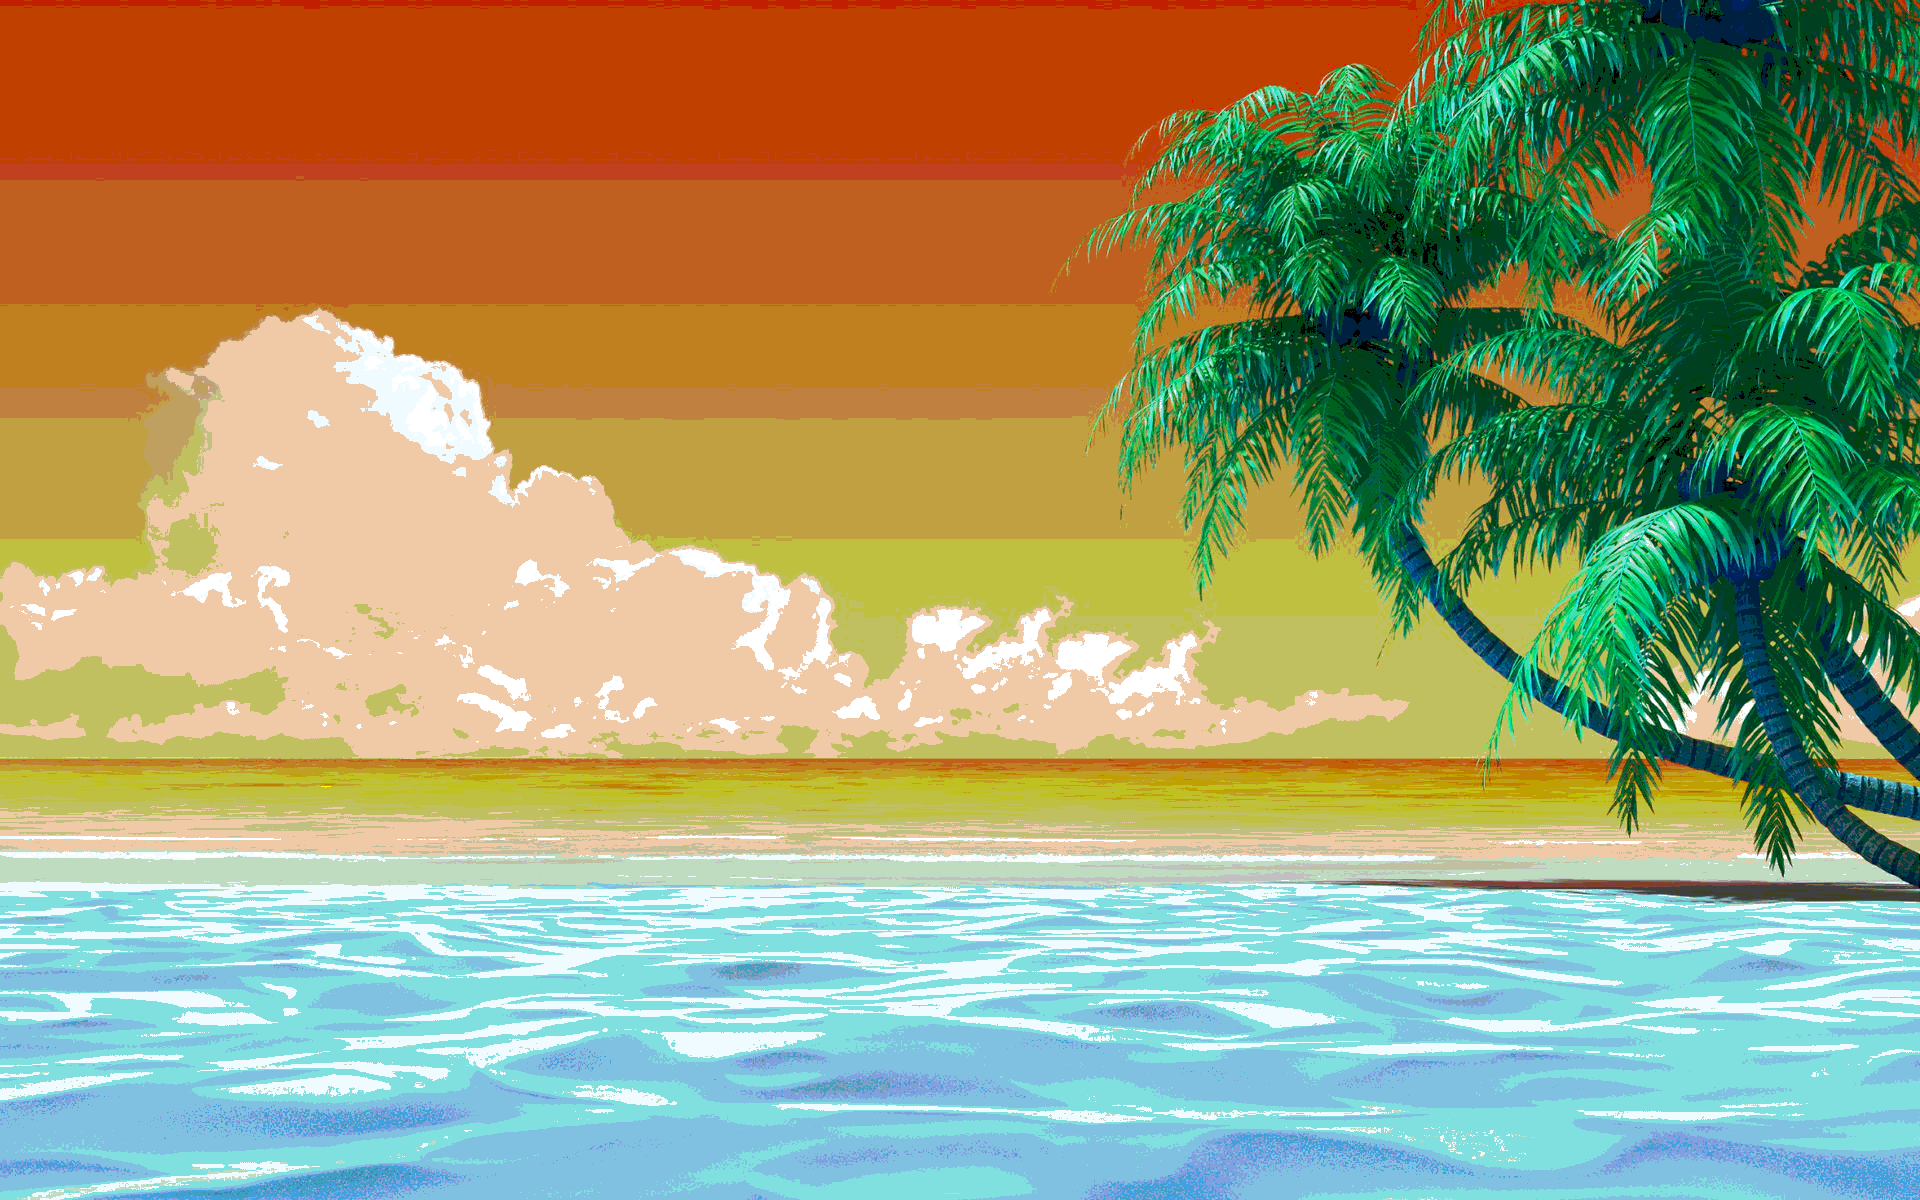

In [119]:
cv2_imshow(original_image)

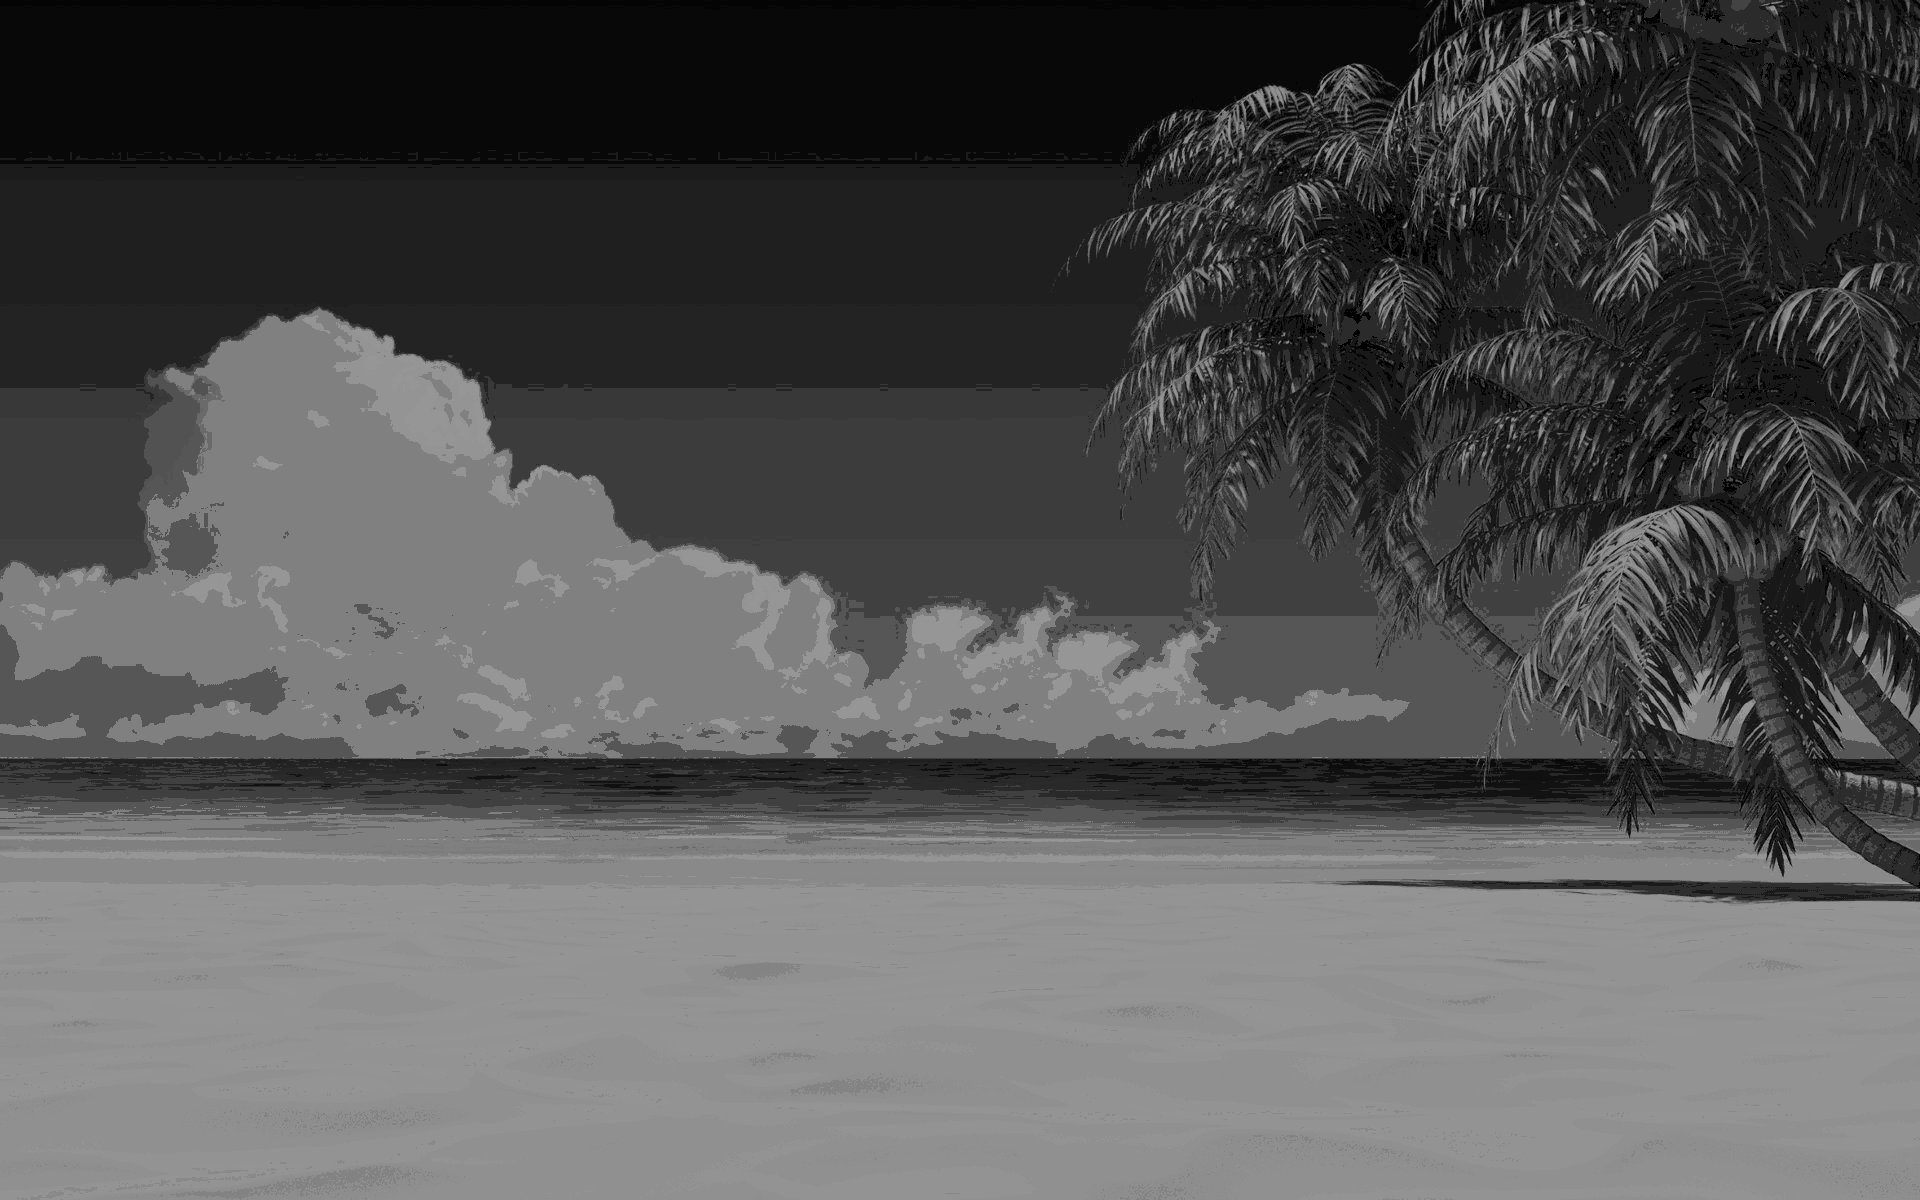

In [124]:
encoded_image_cpu = encoded_image.cpu().numpy()
cv2_imshow(encoded_image_cpu)

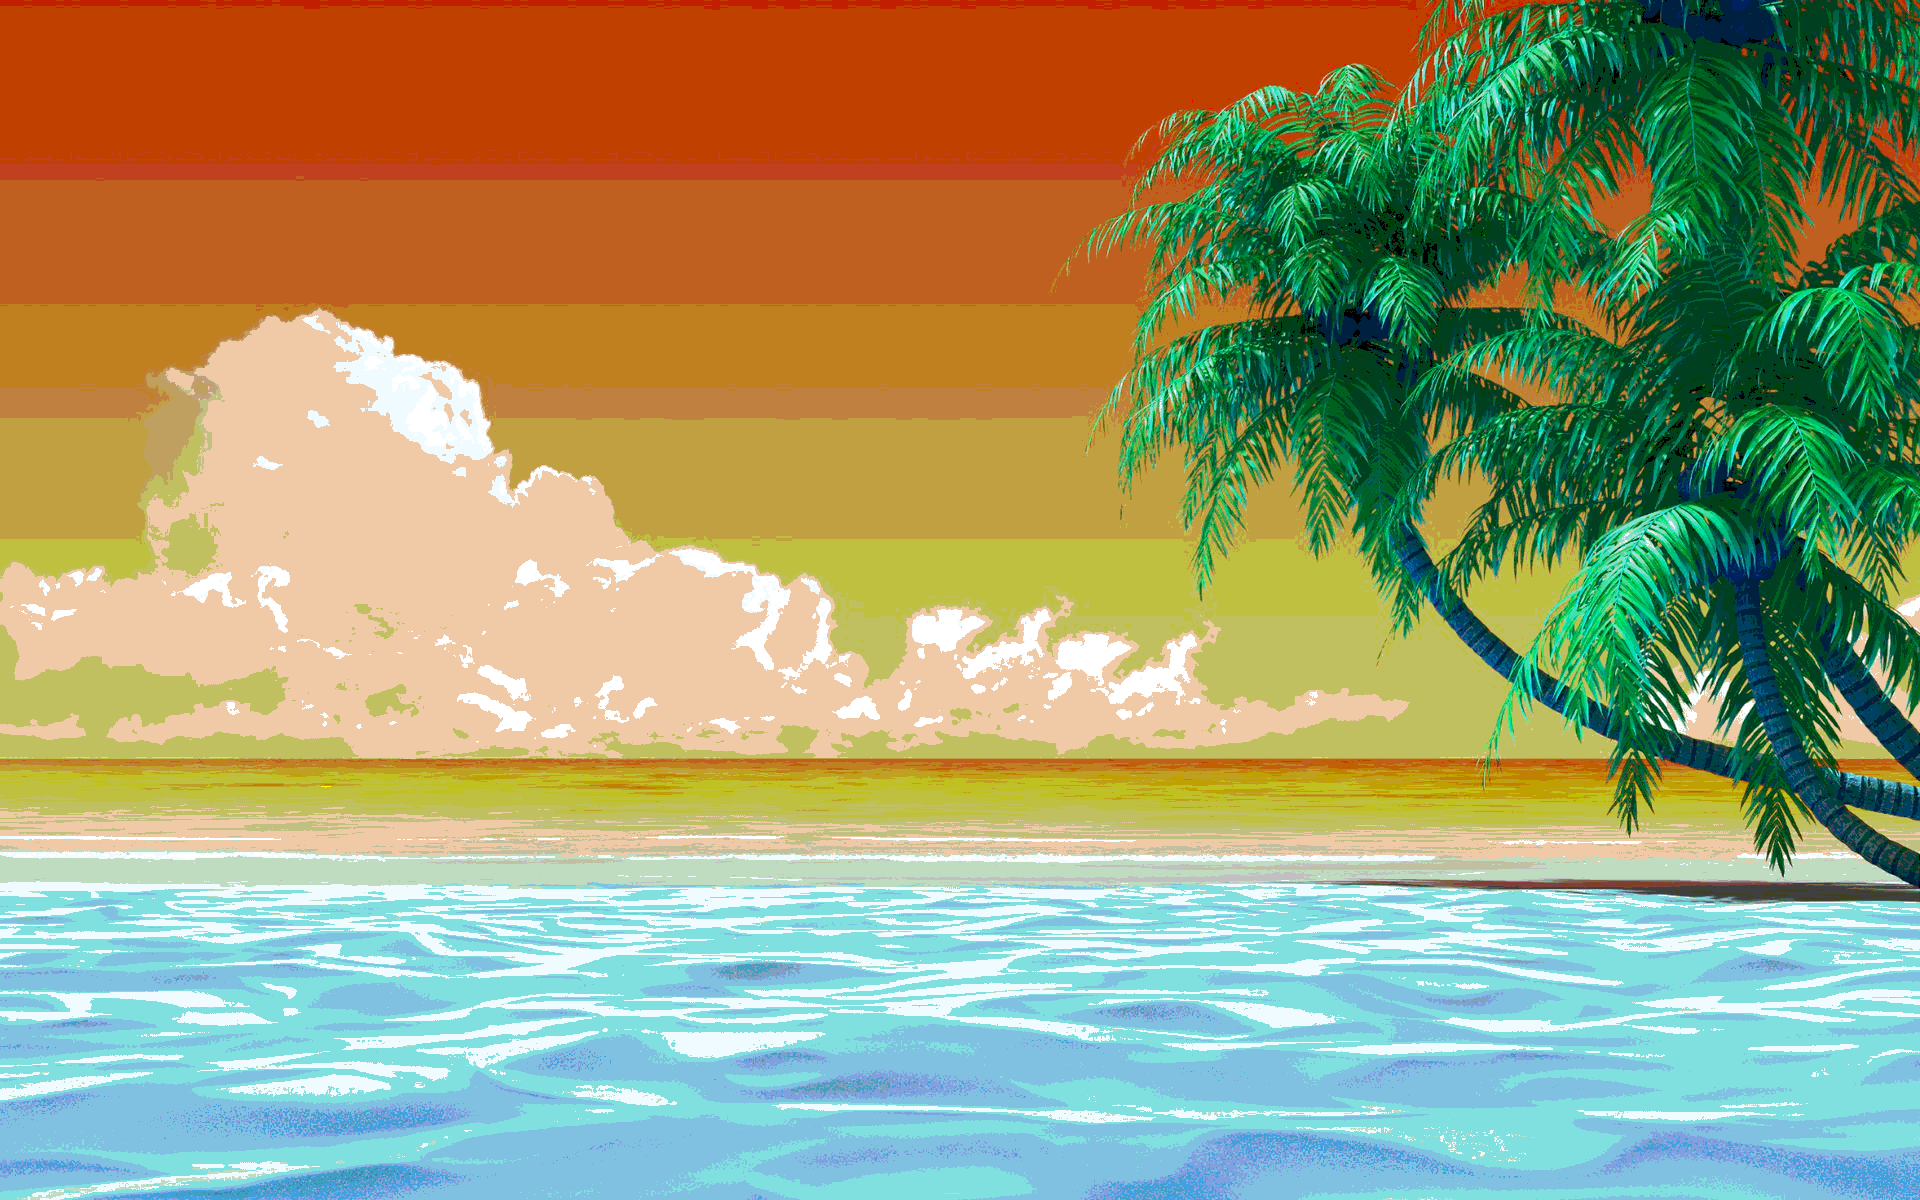

In [125]:
decoded_image_cpu = decoded_image.cpu().numpy()
cv2_imshow(decoded_image_cpu)

### Реализация на Cuda без константной памяти

In [112]:
# Функция создания массива уникальных цветов
def create_unique_colors(image):
    # Используем np.unique для поиска уникальных цветов в изображении
    unique_colors, counts = np.unique(image.reshape(-1, 3), axis=0, return_counts=True)
    return unique_colors

# Функция кодирования изображения
@cuda.jit
def encode_image_cuda(image, encoded_image, unique_colors):
    # Определение индексов блока и нити
    i, j = cuda.grid(2)
    # Проверка, что индексы находятся в пределах размеров изображения
    if i < image.shape[0] and j < image.shape[1]:
        # Получаем цвет текущего пикселя
        pixel = (image[i, j, 0], image[i, j, 1], image[i, j, 2])
        # Ищем соответствующий индекс цвета в массиве уникальных цветов
        index = -1
        for k in range(len(unique_colors)):
            color = unique_colors[k]
            if pixel[0] == color[0] and pixel[1] == color[1] and pixel[2] == color[2]:
                index = k
                break
        # Записываем индекс в закодированное изображение
        encoded_image[i, j] = index

# Функция декодирования изображения
@cuda.jit
def decode_image_cuda(encoded_image, decoded_image, unique_colors):
    # Определение индексов блока и нити
    i, j = cuda.grid(2)
    # Проверка, что индексы находятся в пределах размеров закодированного изображения
    if i < encoded_image.shape[0] and j < encoded_image.shape[1]:
        # Получаем индекс цвета из закодированного изображения
        index = encoded_image[i, j]
        # Получаем соответствующий цвет из массива уникальных цветов и записываем его в декодированное изображение
        color = unique_colors[index]
        decoded_image[i, j, 0] = color[0]
        decoded_image[i, j, 1] = color[1]
        decoded_image[i, j, 2] = color[2]

In [114]:
start_palette = time.time()
# Создание массива уникальных цветов
unique_colors = create_unique_colors(original_image)
end_palette = time.time()

start_transfer_to_GPU = time.time()
# Переносим изображение на GPU
image_gpu = cuda.to_device(original_image)
end_transfer_to_GPU = time.time()

# Определяем параметры блоков и сеток для запуска на GPU
threads_per_block = (16, 16)
blocks_per_grid_x = (original_image.shape[0] + threads_per_block[0] - 1) // threads_per_block[0]
blocks_per_grid_y = (original_image.shape[1] + threads_per_block[1] - 1) // threads_per_block[1]
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)
# Создаем пустой массив для закодированного изображения на GPU
encoded_image_gpu = cuda.device_array_like(original_image[:, :, 0])
# Создаем пустой массив для декодированного изображения на GPU
decoded_image_gpu = cuda.device_array_like(original_image)

# Запуск кодирования на GPU
start_coding = time.time()
encode_image_cuda[blocks_per_grid, threads_per_block](image_gpu, encoded_image_gpu, unique_colors)
cuda.synchronize()
end_coding = time.time()

# Запуск декодирования на GPU
start_decoding = time.time()
decode_image_cuda[blocks_per_grid, threads_per_block](encoded_image_gpu, decoded_image_gpu, unique_colors)
cuda.synchronize()
end_decoding = time.time()

# Побайтовое сравнение исходного и декодированного изображений
if np.array_equal(original_image, decoded_image_gpu):
    print("Декодирование выполнено корректно")
else:
    print("Декодирование не удалось")

palette_time_СPU = end_palette - start_palette
transfer_to_GPU = end_transfer_to_GPU - start_transfer_to_GPU
coding_time_GPU = end_coding - start_coding
decoding_time_GPU = end_decoding - start_decoding
all_time =coding_time_GPU + decoding_time_GPU + palette_time_СPU + transfer_to_GPU

print(f"Общее время выполнения: {all_time:.2f} сек")
print(f"Время создания палитры на CPU: {palette_time_CPU:.4f} сек")
print(f"Время перемещения картинки на GPU: {transfer_to_GPU:.4f} сек")
print(f"Время кодирования изображения на GPU: {coding_time_GPU:.6f} сек")
print(f"Время декодирования изображения на GPU: {decoding_time_GPU:.6f} сек")

Декодирование выполнено корректно
Общее время выполнения: 3.48 сек
Время создания палитры на CPU: 5.0491 сек
Время перемещения картинки на GPU: 0.0024 сек
Время кодирования изображения на GPU: 0.003826 сек
Время декодирования изображения на GPU: 0.001312 сек


#### Результаты

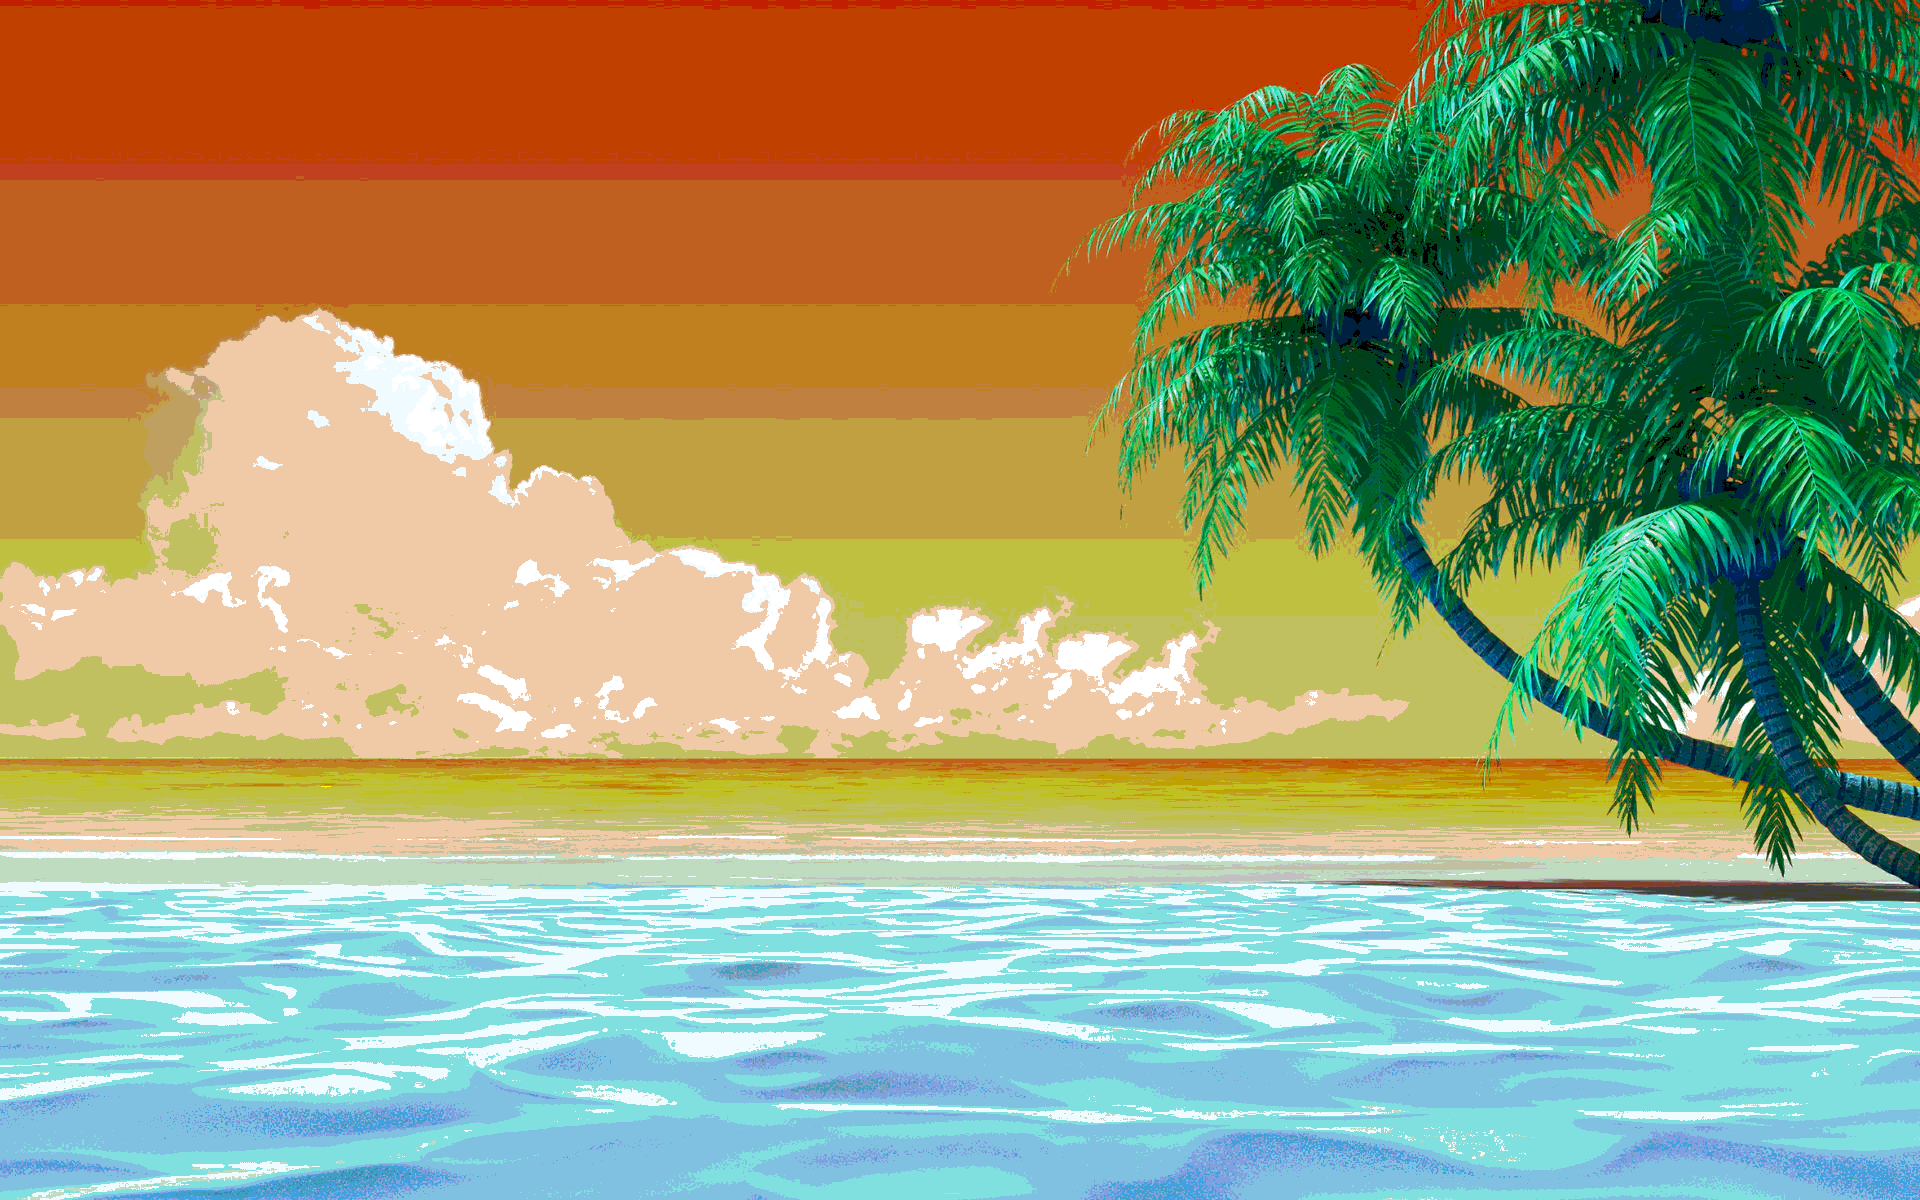

In [54]:
cv2_imshow(original_image)

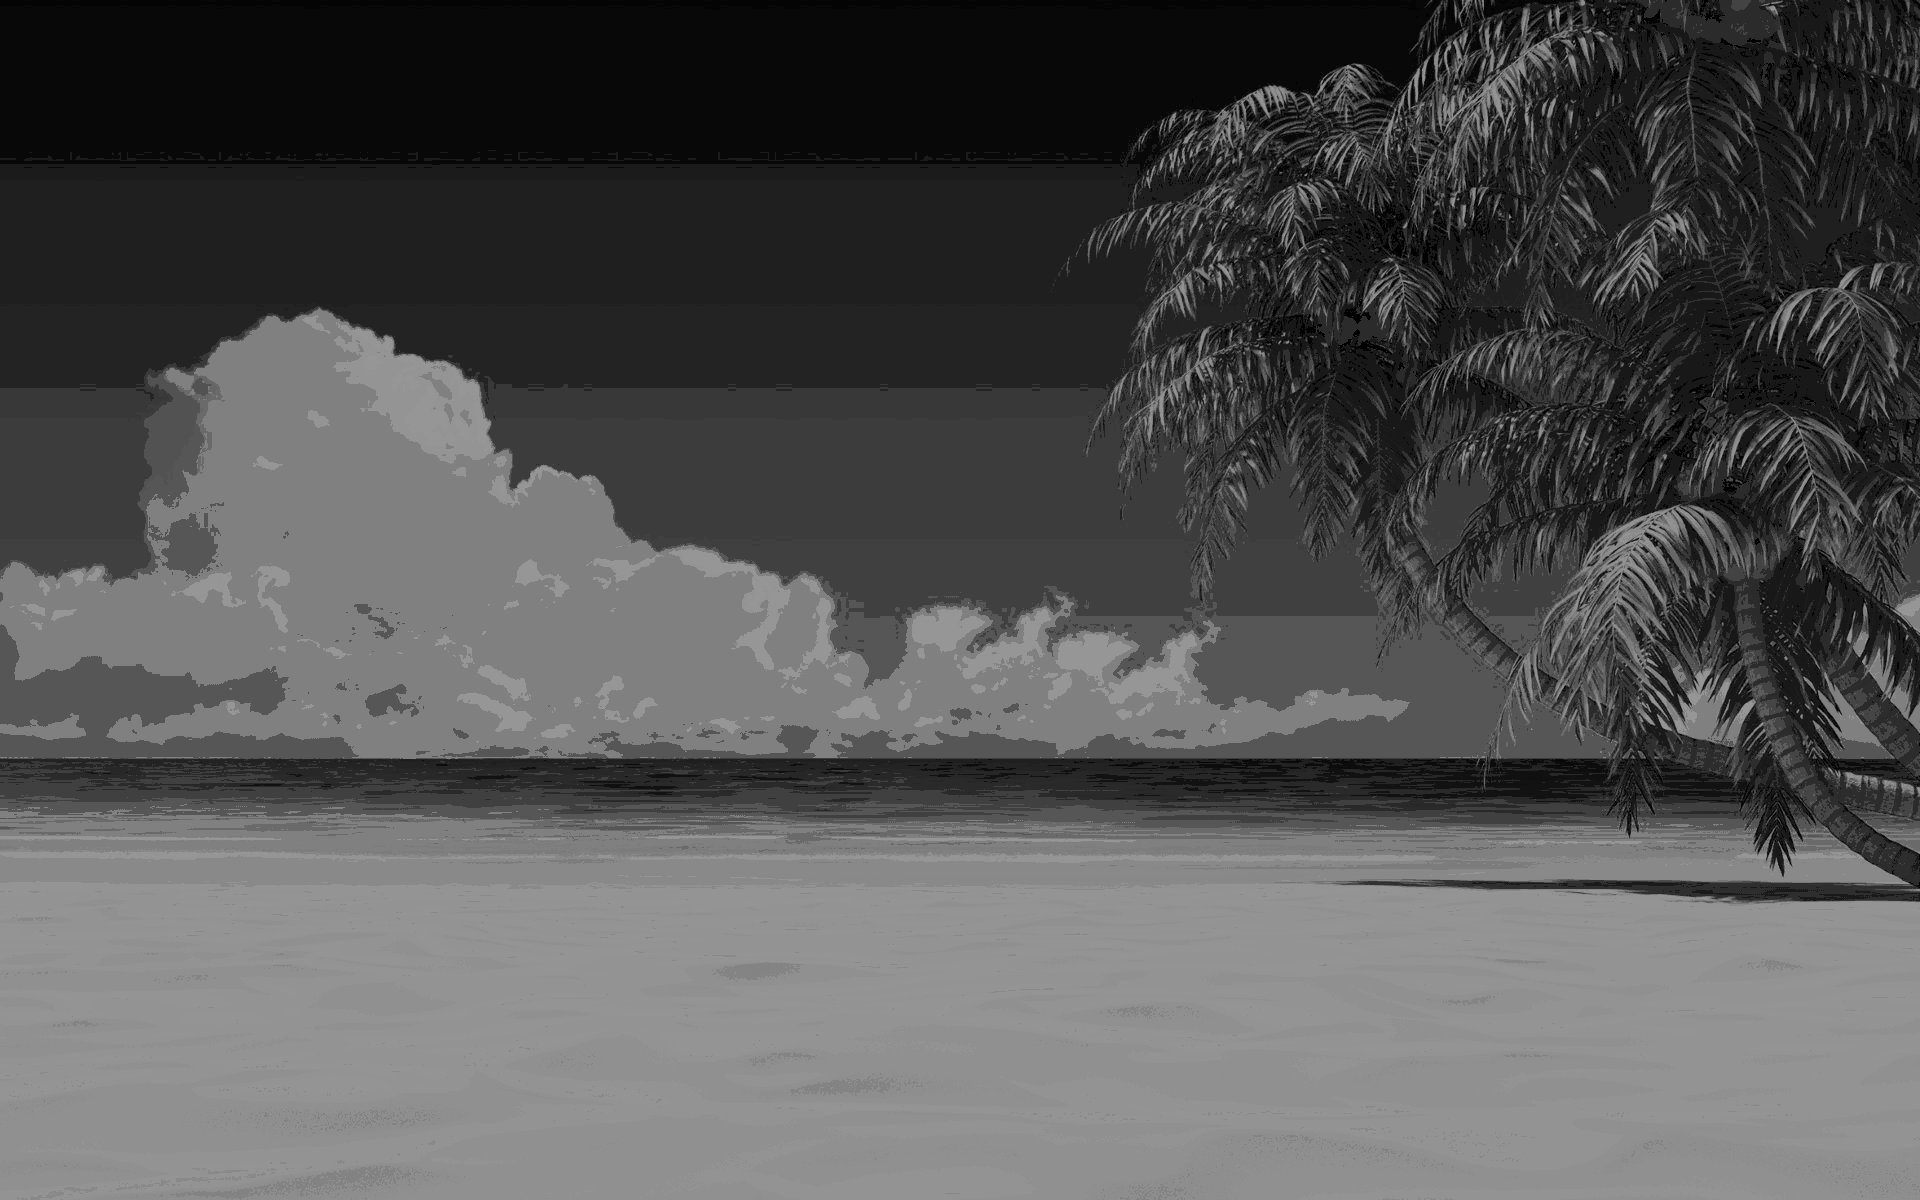

In [93]:
# Создание массива на хосте для закодированного изображения
encoded_image_host = np.empty_like(original_image[:, :, 0])
# Копирование данных с устройства GPU на устройство CPU
encoded_image_gpu.copy_to_host(encoded_image_host)
cv2_imshow(encoded_image_host)

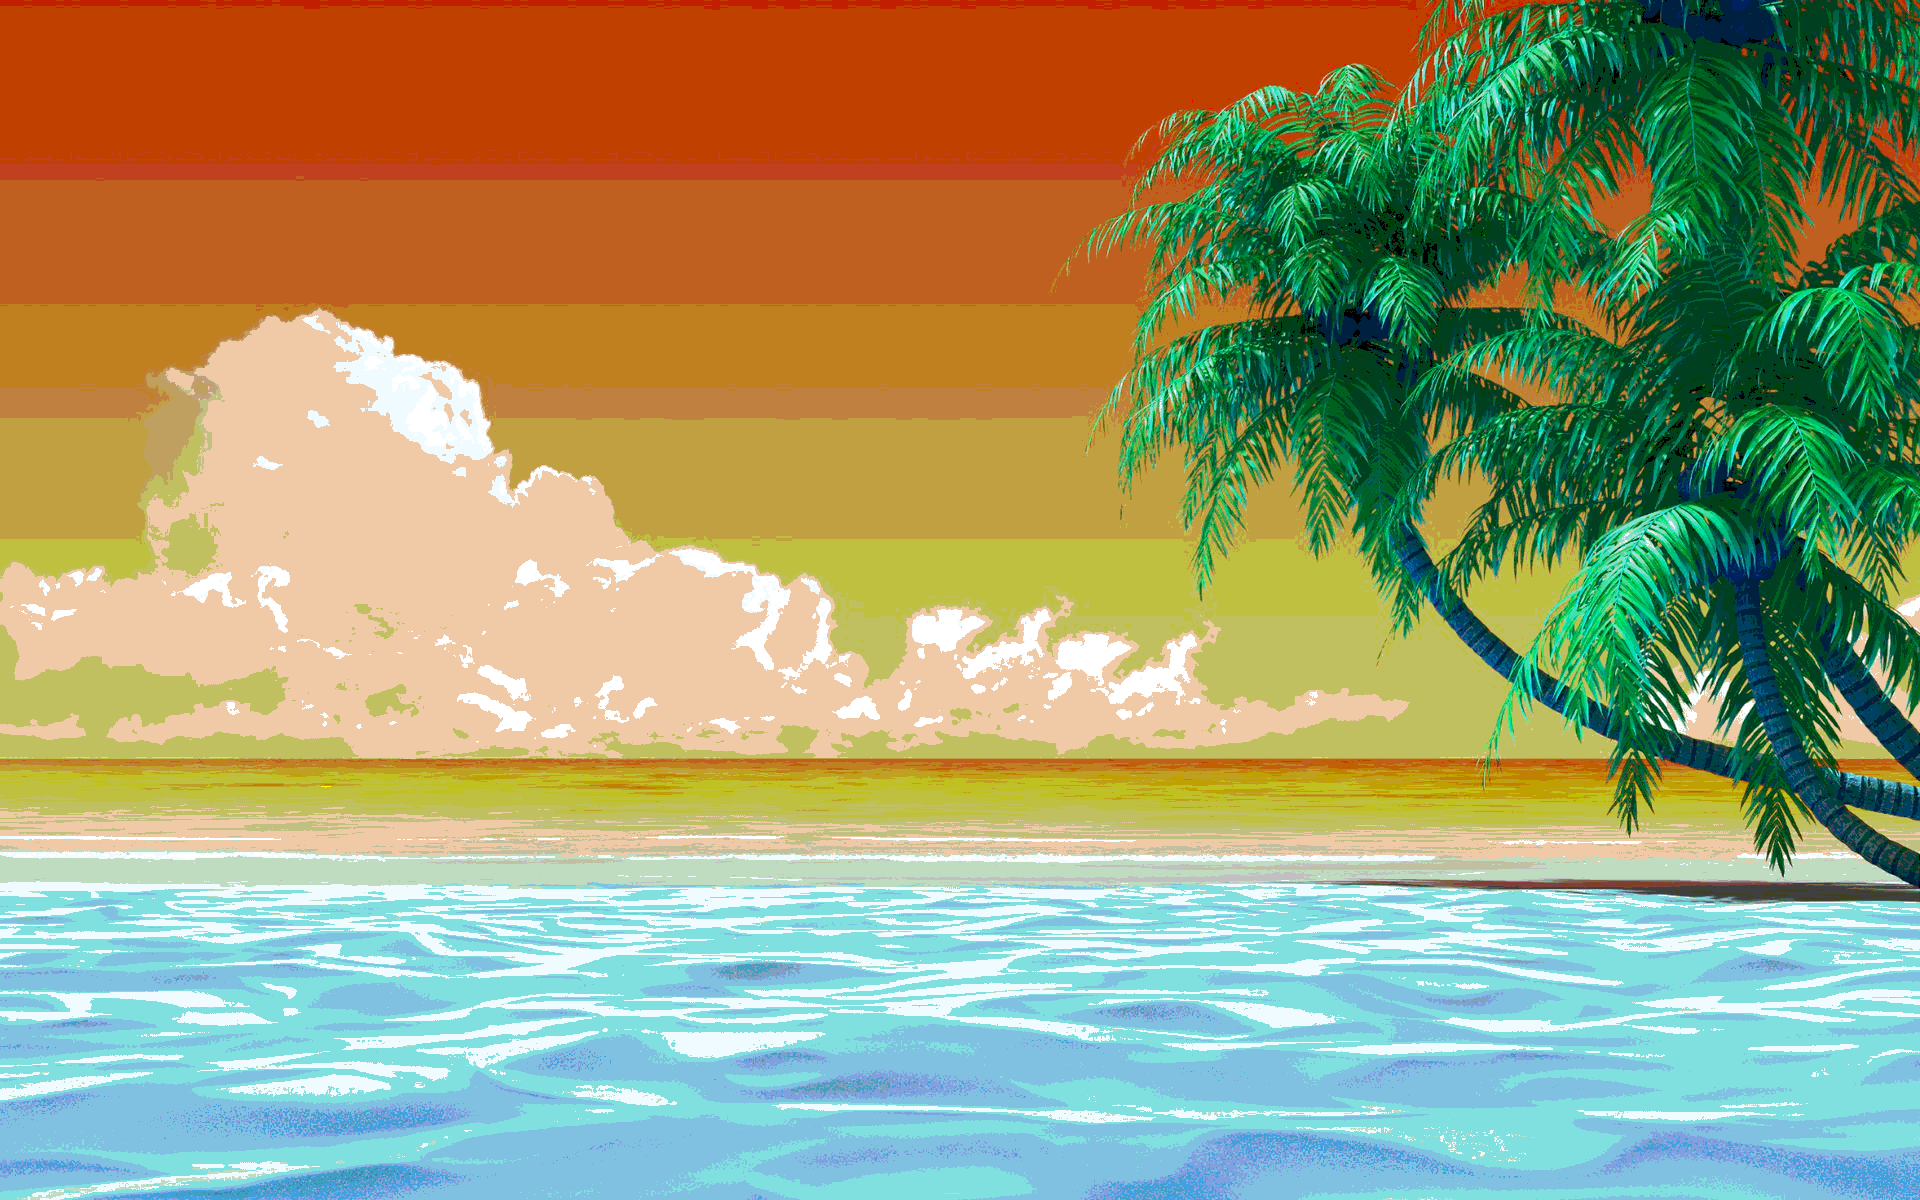

In [90]:
decoded_image_host = np.empty_like(original_image)
# Копирование данных с устройства CUDA на хост
decoded_image_gpu.copy_to_host(decoded_image_host)
cv2_imshow(decoded_image_host)

### Реализация на Cuda с константной памятью

In [95]:
# Функция создания массива уникальных цветов
def create_unique_colors(image):
    # Используем np.unique для поиска уникальных цветов в изображении
    unique_colors, counts = np.unique(image.reshape(-1, 3), axis=0, return_counts=True)
    return unique_colors

# Функция кодирования изображения
@cuda.jit
def encode_image_cuda(image, encoded_image, palette, palette_size):
    # Определение индексов блока и нити
    i, j = cuda.grid(2)
    # Проверка, что индексы находятся в пределах размеров изображения
    if i < image.shape[0] and j < image.shape[1]:
        # Получаем цвет текущего пикселя
        pixel = (image[i, j, 0], image[i, j, 1], image[i, j, 2])
        # Ищем соответствующий индекс цвета в массиве палитры
        index = -1
        for k in range(palette_size):
            color = palette[k]
            if pixel[0] == color[0] and pixel[1] == color[1] and pixel[2] == color[2]:
                index = k
                break
        # Записываем индекс в закодированное изображение
        encoded_image[i, j] = index

# Функция декодирования изображения
@cuda.jit
def decode_image_cuda(encoded_image, decoded_image, palette, palette_size):
    # Определение индексов блока и нити
    i, j = cuda.grid(2)
    # Проверка, что индексы находятся в пределах размеров закодированного изображения
    if i < encoded_image.shape[0] and j < encoded_image.shape[1]:
        # Получаем индекс цвета из закодированного изображения
        index = encoded_image[i, j]
        # Получаем соответствующий цвет из массива палитры и записываем его в декодированное изображение
        color = palette[index]
        decoded_image[i, j, 0] = color[0]
        decoded_image[i, j, 1] = color[1]
        decoded_image[i, j, 2] = color[2]

In [107]:
start_palette = time.time()
# Создание массива уникальных цветов
unique_colors = create_unique_colors(original_image)
# Паддинг массива нулями до размера MAX_PALETTE_SIZE
unique_colors_padded = np.pad(unique_colors, [(0, MAX_PALETTE_SIZE - len(unique_colors)), (0, 0)], mode='constant')
# Создаем массив для палитры на GPU
palette_gpu = cuda.to_device(unique_colors_padded)
end_palette = time.time()

start_transfer_to_GPU = time.time()
# Переносим изображение на GPU
image_gpu = cuda.to_device(original_image)
end_transfer_to_GPU = time.time()

# Определяем параметры блоков и сеток для запуска на GPU
threads_per_block = (16, 16)
blocks_per_grid_x = (original_image.shape[0] + threads_per_block[0] - 1) // threads_per_block[0]
blocks_per_grid_y = (original_image.shape[1] + threads_per_block[1] - 1) // threads_per_block[1]
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

# Запуск кодирования на GPU
start_coding = time.time()
encode_image_cuda[blocks_per_grid, threads_per_block](image_gpu, encoded_image_gpu, palette_gpu, len(unique_colors))
cuda.synchronize()
end_coding = time.time()

# Запуск декодирования на GPU
start_decoding = time.time()
decode_image_cuda[blocks_per_grid, threads_per_block](encoded_image_gpu, decoded_image_gpu, palette_gpu, len(unique_colors))
cuda.synchronize()
end_decoding = time.time()

# Побайтовое сравнение исходного и декодированного изображений
if np.array_equal(original_image, decoded_image_gpu):
    print("Декодирование выполнено корректно")
else:
    print("Декодирование не удалось")

palette_time_CPU = end_palette - start_palette
transfer_to_GPU = end_transfer_to_GPU - start_transfer_to_GPU
coding_time_GPU = end_coding - start_coding
decoding_time_GPU = end_decoding - start_decoding
all_time =coding_time_GPU + decoding_time_GPU + palette_time_CPU + transfer_to_GPU

print(f"Общее время выполнения: {all_time:.2f} сек")
print(f"Время создания палитры на CPU: {palette_time_CPU:.4f} сек")
print(f"Время перемещения картинки на GPU: {transfer_to_GPU:.4f} сек")
print(f"Время кодирования изображения на GPU: {coding_time_GPU:.6f} сек")
print(f"Время декодирования изображения на GPU: {decoding_time_GPU:.6f} сек")

Декодирование выполнено корректно
Общее время выполнения: 5.06 сек
Время создания палитры на CPU: 5.0491 сек
Время перемещения картинки на GPU: 0.0023 сек
Время кодирования изображения на GPU: 0.003369 сек
Время декодирования изображения на GPU: 0.000932 сек


#### Результаты

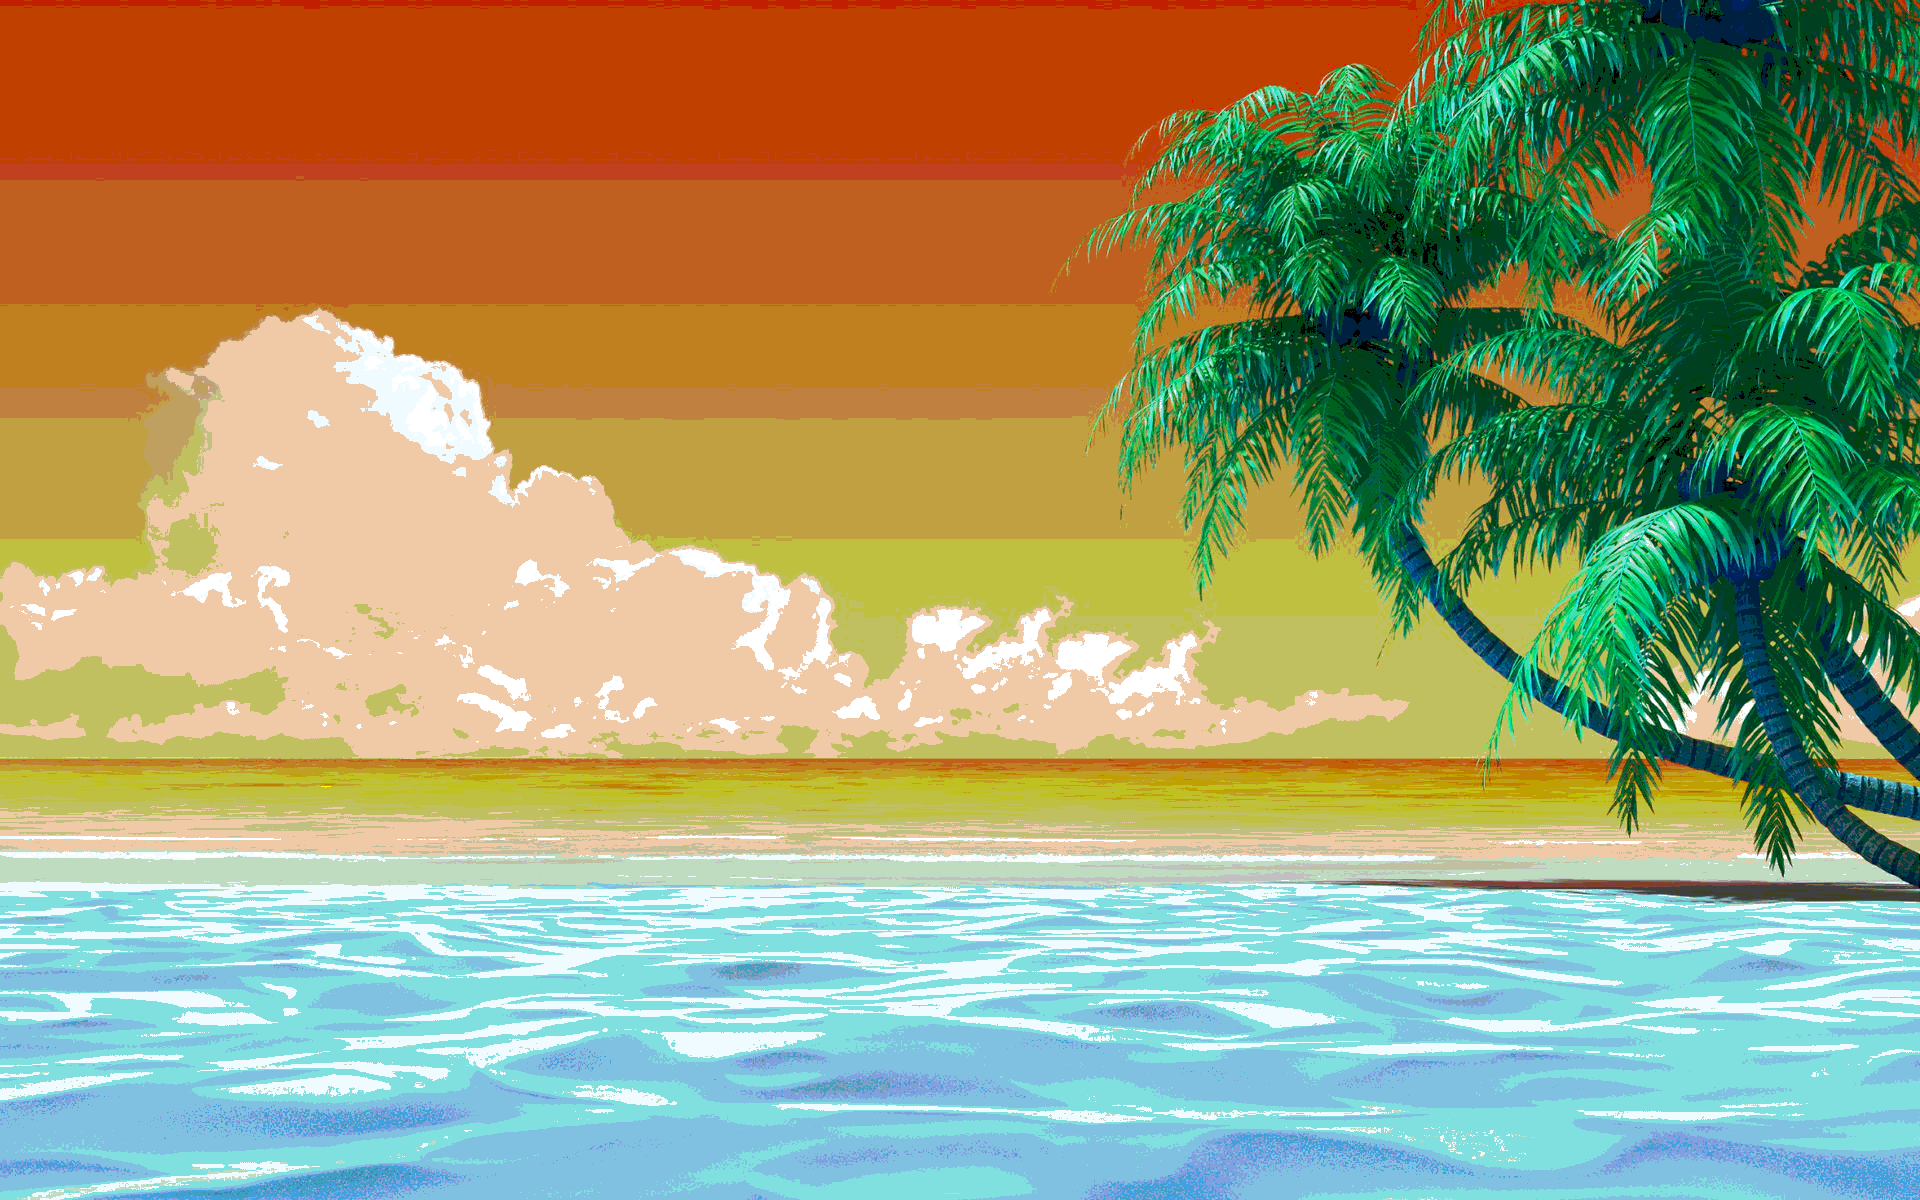

In [108]:
cv2_imshow(original_image)

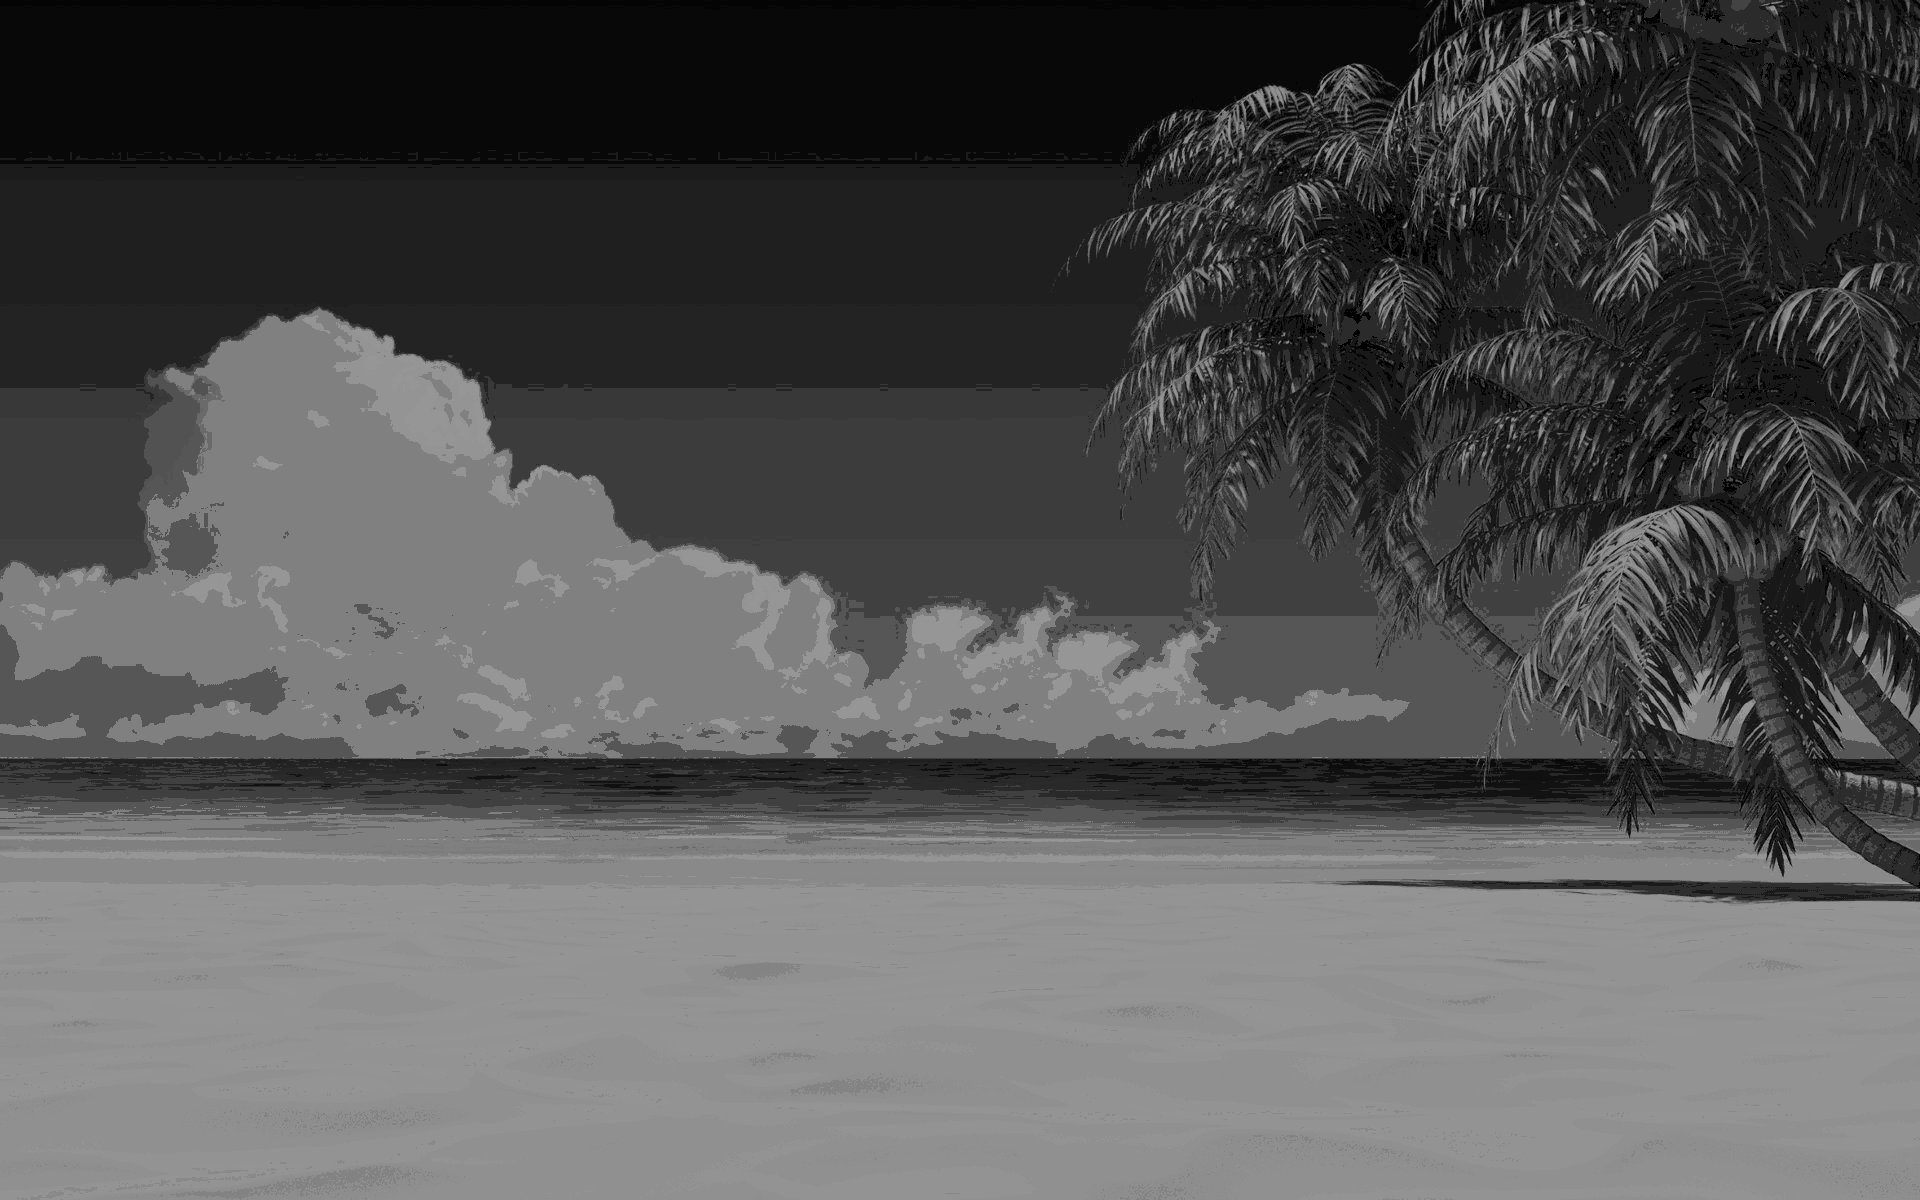

In [109]:
# Создание массива на хосте для закодированного изображения
encoded_image_host = np.empty_like(original_image[:, :, 0])
# Копирование данных с устройства GPU на устройство CPU
encoded_image_gpu.copy_to_host(encoded_image_host)
cv2_imshow(encoded_image_host)

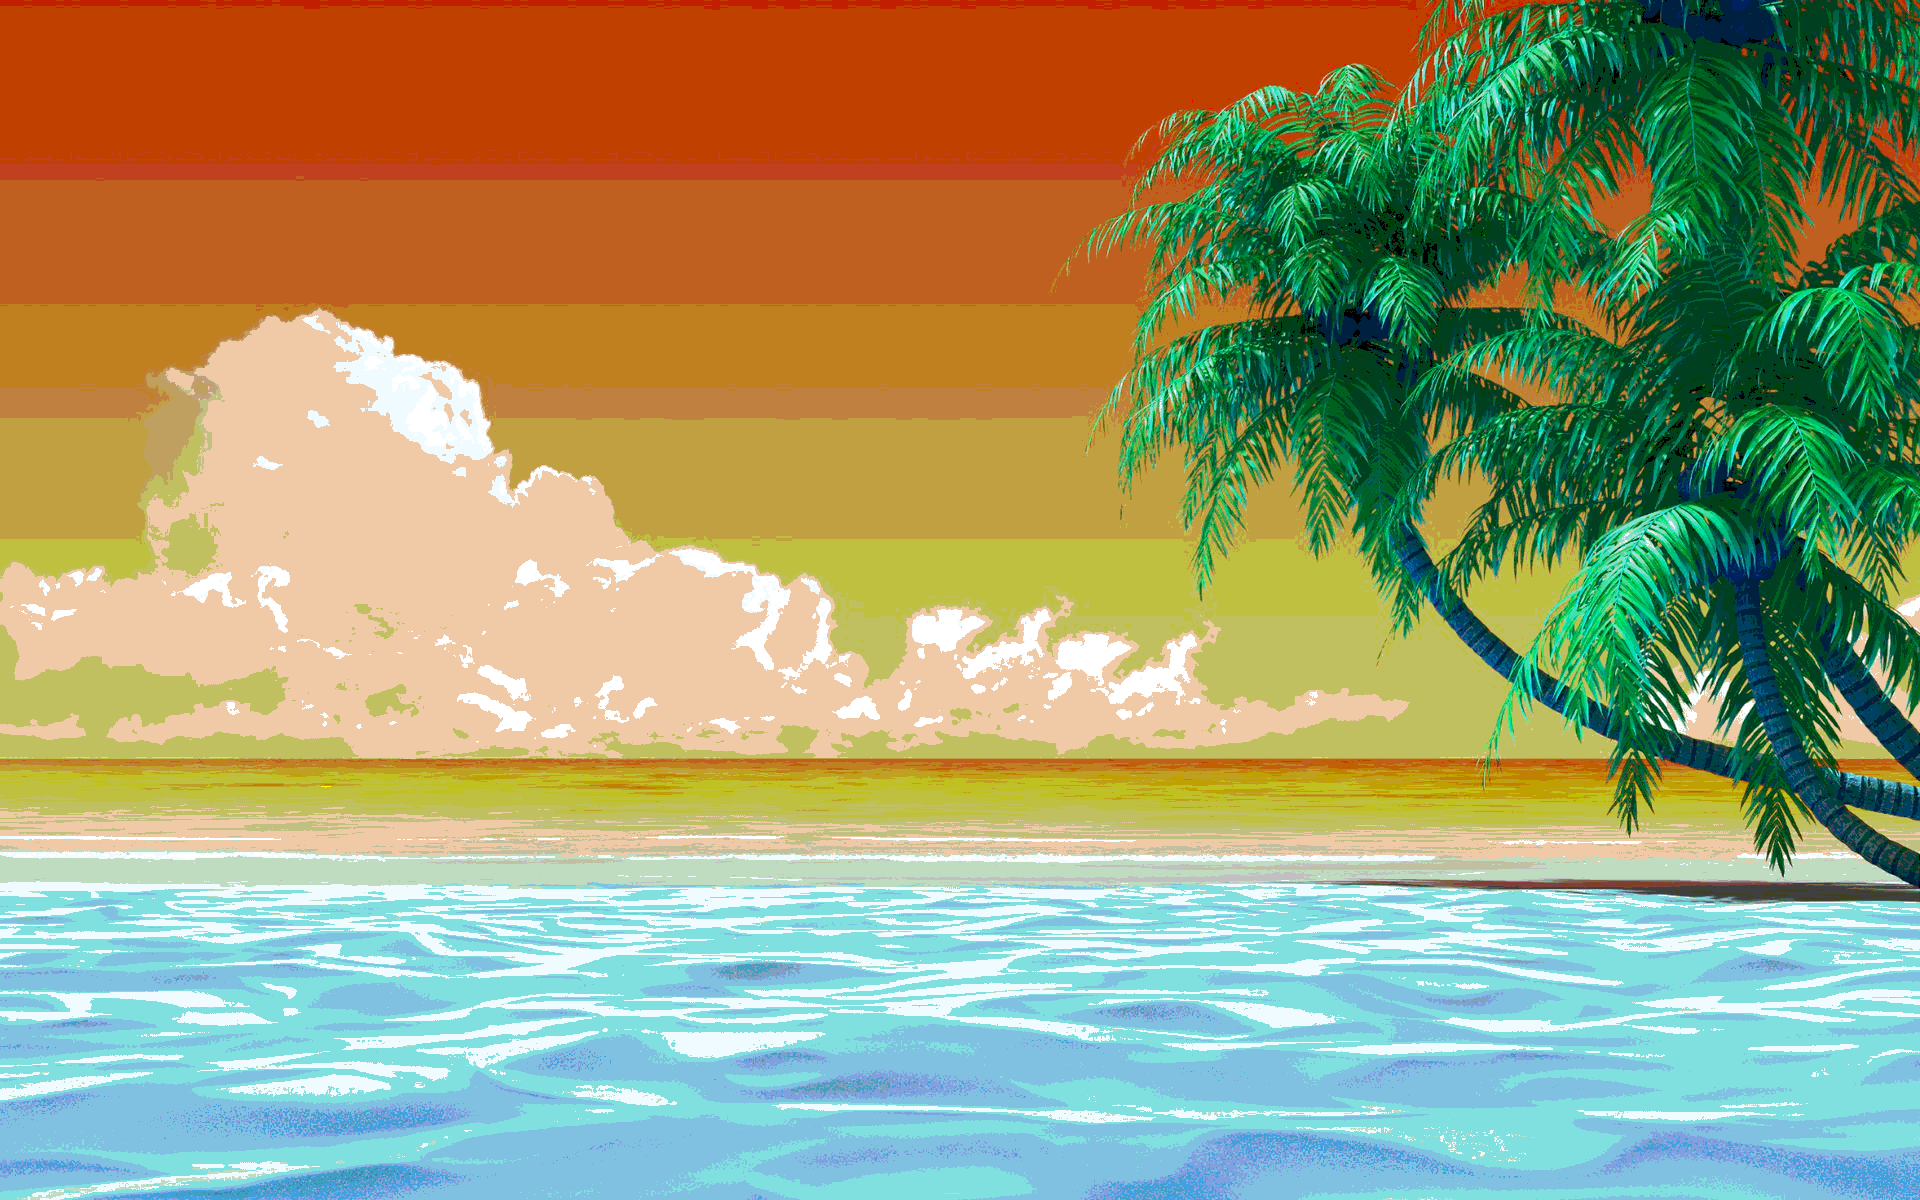

In [110]:
decoded_image_host = np.empty_like(original_image)
# Копирование данных с устройства CUDA на хост
decoded_image_gpu.copy_to_host(decoded_image_host)
cv2_imshow(decoded_image_host)